# Нахождения похожих товаров в интернет-магазинах по их описанию

## задача :

- по описанию одежды для активного отдыха найти похожую. Для решения задачи должно использоваться косинусное расстояние между веторами признаков описания.

### Оглавление

* [1 : Предварительная подготовка](#chapter1)
    * [1.1 : Загрузка библиотек и данных](#section_1_1)
    * [1.2 : Предварительная подготовка текста](#section_1_2)
    

* [2 Кластеризация](#chapter2)

* [3 Рекомендательная система](#chapter3)


## 1 : Предварительная обработка<a class="anchor" id="chapter1"></a>

### 1.1 : Загрузка библиотек и данных <a class="anchor" id="section_1_1"></a>

In [1]:
%pip install spacy -q

In [2]:
!python -m spacy download en -q

In [3]:
%pip install wordcloud

In [4]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import re
import gensim.downloader
from gensim.models import word2vec

import matplotlib.pyplot as plt
import wordcloud

Процедуры для подбора рекомендаций

In [30]:
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    
def item(item_id):
    """
    Функция для выдачи названия товара по id.
    :param item_id: id товара, для которого нужно вычленить название из полного описания.
    :return name: название товара
    """
    return corpus.loc[corpus['id'] == item_id]['description'].tolist()[0].split(' - ')[0]


def recommend(sim_matrix, item_id, num, threshold):
    """
    Функция для нахождения наиболее похожих товаров по матрице расстояний.
    :param sim_matrix: матрица попарных расстояний между всеми примерами в датасете
    :param item_id: id товара для поиска наиболее похожих
    :param num: сколько похожих товаров найти
    :threshold: порог для отбора похожих товаров
    """
    try:
        index=corpus.index[corpus['id']==item_id].tolist()[0] 
    except:
        print('Товар не найден. Пожалуйста введите валидный id.')
    else:
        print(f"{bcolors.OKBLUE}Товар найден :")
        print(corpus['description'][index])            
        print(f"{bcolors.OKGREEN}Топ " + str(num) + " товаров, похожих на " + item(item_id) + "...")
        print("-------")
        similar_indices = sim_matrix[index].argsort()[:-(num+2):-1]
        for ind in similar_indices[1:]:
            if sim_matrix[index][ind] > threshold:
                print(f"{bcolors.OKGREEN}Item #", ind)
                print("Товар " + item(corpus['id'][ind]) + " (score:" + str(sim_matrix[index][ind]) + ")")
        
        
def find_similar_items(item_id):
    """
    Процедура возвращает 5 товаров, из кластера к кторому принадлежит запрашиваемый item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

def claster_recommend(item_id):
    """
    Процедура осуществляет подбор рекомендаций по кластеризации
    """
    try:
        item_desc = corpus.loc[corpus['id']==item_id, 'clean_description'].values[0]
    except:
        print('Товар не найден. Пожалуйста введите валидный id.')
    else:
        print(f"{bcolors.OKBLUE}Товар найден :")
        print(item_desc)
        print()
        print(f"{bcolors.OKGREEN}Топ товаров, похожих на " + item(item_id) + "...")
        print('-'*7)

        for i in find_similar_items(item_id):
            print(f"{bcolors.OKGREEN}Item #", i)
            print("Товар " + corpus.loc[corpus['id']==i, 'clean_description'].values[0])


Загрузим данные с описанием товаров

In [6]:
corpus = pd.read_csv('data/sample-data.csv')

In [7]:
print(corpus.shape)
corpus.head()

(500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


Посмотрим на описание первого товара

In [8]:
print('Описание первого товара : ',corpus.loc[0,'description'])

Описание первого товара :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight

Описание содержит html тэги, которые нужно удалить, а так же нужно убрать пунктуацию и стандартизировать слова текста

### 1.2 : Предварительная обработка текста <a class="anchor" id="section_1_2"></a>

Очистим текст и сохраним результат в колонку **clean_description**

In [9]:
# Удалим HTML тэги, спецсимволы и цифры 
p = re.compile(r'\d+|\/|\"|\%|\(|\)|<.*?>')

corpus['clean_description'] = corpus['description'].apply(lambda x: p.sub(' ',x)) 
print('Очищенное описание первого товара : ',corpus.loc[0,'clean_description'])

Очищенное описание первого товара :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of  . -oz    recycled polyester with moisture-wicking performance. Inseam  size M  is       . Recyclable through the Common Threads Recycling Program.   Details:     Silky Capilene   fabric is ultralight, breathable and quick-to-dry     Exposed, brushed elastic waistband for comfort     -panel construction with traditional boxer back    Inseam  size M  is              Fabric:   . -oz    all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program   Weight:    g   .  oz   Made in Mexico.


Переведем текст в нижний регистр

In [10]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  active classic boxers - there's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. the quick-drying, lightweight underwear takes up minimal space in a travel pack. an exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. made of  . -oz    recycled polyester with moisture-wicking performance. inseam  size m  is       . recyclable through the common threads recycling program.   details:     silky capilene   fabric is ultralight, breathable and quick-to-dry     exposed, brushed elastic waistband for comfort     -panel construction with traditional boxer back    inseam  size m  is              fabric:   . -oz    all-recycled polyester with gladiodor natural odor control for the garment. recyclable through the common threads recycling program   weight:    g   .  oz   made in mexico.


проведем токенизацию

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"(active, classic, boxers, -, there, 's, a, rea..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"(active, sport, boxer, briefs, -, skinning, up..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"(active, sport, briefs, -, these, superbreatha..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","(alpine, guide, pants, -, skin, in, ,, climb, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","(alpine, wind, jkt, -, on, high, ridges, ,, st..."


Проведем  лемматизацию и удалим стоп слова

In [12]:
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ..."


преобразуем токенизированный документ в строку и запишем с столбец **clean_document**

In [13]:
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin..."


## 2 Кластеризация <a class="anchor" id="chapter2"></a>

1. метод TF-IDF векторизации по колонке **clean_document**

In [14]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

tfidf_matrix = X.toarray()
print(tfidf_matrix.shape)

(500, 3511)


In [15]:
# посомтрим на первые 50 экземпляров
print(sorted(vectorizer.vocabulary_.items())[:50])

[('abandon', 0), ('ability', 1), ('able', 2), ('abrasion', 3), ('abrasive', 4), ('abroad', 5), ('absolute', 6), ('absorb', 7), ('absorption', 8), ('abstract', 9), ('abuse', 10), ('abusive', 11), ('accentuate', 12), ('access', 13), ('accessibility', 14), ('accessory', 15), ('accommodate', 16), ('accomplish', 17), ('accord', 18), ('ace', 19), ('achieve', 20), ('achille', 21), ('act', 22), ('action', 23), ('active', 24), ('activity', 25), ('acutely', 26), ('adapt', 27), ('adaptability', 28), ('adaptable', 29), ('add', 30), ('addition', 31), ('additional', 32), ('adhere', 33), ('adjust', 34), ('adjustability', 35), ('adjustable', 36), ('adjusting', 37), ('adjustment', 38), ('adorn', 39), ('adour', 40), ('adours', 41), ('advance', 42), ('advanced', 43), ('advantage', 44), ('advantageous', 45), ('adventure', 46), ('aerial', 47), ('aesthetic', 48), ('affectionately', 49)]


Посчитаем косинусное расстояние

In [16]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_similarities

array([[1.        , 0.35651831, 0.13326512, ..., 0.08366546, 0.09711728,
        0.0898333 ],
       [0.35651831, 1.        , 0.49061419, ..., 0.08034072, 0.1427709 ,
        0.09469065],
       [0.13326512, 0.49061419, 1.        , ..., 0.08148675, 0.04909818,
        0.0490096 ],
       ...,
       [0.08366546, 0.08034072, 0.08148675, ..., 1.        , 0.06077728,
        0.07581754],
       [0.09711728, 0.1427709 , 0.04909818, ..., 0.06077728, 1.        ,
        0.53241135],
       [0.0898333 , 0.09469065, 0.0490096 , ..., 0.07581754, 0.53241135,
        1.        ]])

2. векторизация word2vec

In [17]:
word_vectors = gensim.downloader.load("glove-wiki-gigaword-300")

def create_embed_matrix(texts):
    """
    Функция для заполнения марицы векторов по корпусу текстов. 
    В качестве вектора для одного текста будем использовать среднее значение word2vec отдельных слов
    :input texts: корпус текстов
    :return embed_matrix: возвращается матрица векторов
    """
    embed_matrix=np.zeros((len(texts),word_vectors.vector_size))
    for ind, text in enumerate(texts):
        mean_word2vec=np.zeros(word_vectors.vector_size)
        num_words=0
        #Перебор всех слов из текста и суммирование векторов
        for word in text:
            if word in word_vectors.index_to_key:
                mean_word2vec+=word_vectors[word]
                num_words+=1
        embed_matrix[ind]=mean_word2vec/num_words
        #Нормализация финального вектора для одного тектса
        embed_matrix[ind]=embed_matrix[ind]/np.sqrt(np.sum(embed_matrix[ind]**2)) 
    return embed_matrix

[==================================================] 100.0% 376.1/376.1MB downloaded


Посчитаем косинусное расстояние

In [18]:
mean_word2vec_matrix=create_embed_matrix(corpus['clean_document'].values)
cosine_similarities_w2v = cosine_similarity(mean_word2vec_matrix, mean_word2vec_matrix)
cosine_similarities_w2v 

array([[1.        , 0.99665608, 0.99744088, ..., 0.99558764, 0.99813638,
        0.99757689],
       [0.99665608, 1.        , 0.99917866, ..., 0.99780499, 0.99674029,
        0.99632784],
       [0.99744088, 0.99917866, 1.        , ..., 0.99758985, 0.99763785,
        0.99716002],
       ...,
       [0.99558764, 0.99780499, 0.99758985, ..., 1.        , 0.99516206,
        0.99644805],
       [0.99813638, 0.99674029, 0.99763785, ..., 0.99516206, 1.        ,
        0.99819769],
       [0.99757689, 0.99632784, 0.99716002, ..., 0.99644805, 0.99819769,
        1.        ]])

3. Векторизация doc2vec

In [19]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus["clean_tokens"])]
# Init the Doc2Vec model
model = Doc2Vec(vector_size=50, window=3, min_count=2, workers=4, epochs=40)
# создаем словарь
model.build_vocab(docs)
# тренируем  Doc2Vec model
model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)
corpus['d2w_vectors'] = corpus["clean_tokens"].apply(lambda x: model.infer_vector(x))

Посчитаем косинусное расстояние

In [20]:
temp = pd.DataFrame([x for x in corpus['d2w_vectors']])
cosine_similarities_d2v = cosine_similarity(temp)
cosine_similarities_d2v

array([[ 1.0000001 ,  0.5574101 ,  0.4703913 , ..., -0.01954132,
         0.52447754,  0.40195218],
       [ 0.5574101 ,  1.0000002 ,  0.74000794, ..., -0.0388193 ,
         0.35934222,  0.16663271],
       [ 0.4703913 ,  0.74000794,  1.0000001 , ...,  0.09998246,
         0.20225374,  0.05515526],
       ...,
       [-0.01954132, -0.0388193 ,  0.09998246, ...,  1.0000002 ,
         0.01381202,  0.01496435],
       [ 0.52447754,  0.35934222,  0.20225374, ...,  0.01381202,
         0.9999997 ,  0.789498  ],
       [ 0.40195218,  0.16663271,  0.05515526, ...,  0.01496435,
         0.789498  ,  0.9999999 ]], dtype=float32)

4. Подготовим DataFrame для применеия кластеризации

In [21]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,0
item_0,"(0, 1842)\t0.10070410165358529\n (0, 3417)\..."
item_1,"(0, 1578)\t0.10564857183566699\n (0, 1202)\..."
item_2,"(0, 2605)\t0.07853756229763083\n (0, 1505)\..."
item_3,"(0, 3340)\t0.05844157224927145\n (0, 779)\t..."
item_4,"(0, 482)\t0.05042010978108936\n (0, 3186)\t..."


Используем DBSCAN для кластеризации TF-IDF матрицы

In [22]:
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")
clustering.fit(X)
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,d2w_vectors,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...,"[0.6328544, -0.31373608, -0.660227, 0.16125911...",0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...,"[1.2399272, -0.2759568, -1.1775103, -0.2413831...",0
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...,"[0.48090327, 0.035779886, -1.1870877, 0.361716...",0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ...","[0.4441539, 1.1350085, 0.1708128, -1.0421152, ...",1
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin...","[-1.4619558, -0.11786345, 1.5071446, -0.739469...",1


,0,cluster_id
item_0,"(0, 1842)\t0.10070410165358529\n (0, 3417)\...",0
item_1,"(0, 1578)\t0.10564857183566699\n (0, 1202)\...",0
item_2,"(0, 2605)\t0.07853756229763083\n (0, 1505)\...",0
item_3,"(0, 3340)\t0.05844157224927145\n (0, 779)\t...",1
item_4,"(0, 482)\t0.05042010978108936\n (0, 3186)\t...",1


In [23]:
# номера документов в кластерах
corpus['cluster_id'].value_counts()

 1     229
 0      68
 4      57
-1      33
 2      29
 8      24
 14     13
 3       9
 6       8
 11      7
 10      5
 7       4
 9       4
 13      4
 5       3
 12      3
Name: cluster_id, dtype: int64

In [24]:
# напечатаем 3 документа из 3-х первых кластеров
for c in corpus['cluster_id'].value_counts().index[:3] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  1  :
----
guide jkt - sharp granite, sticky verglas, untracked lines - enjoy them all in this all-around workhorse soft shell. extremely durable, stretchy and breathable, the  -way-stretch polyester double weave allows for an excellent fit while resisting wind, water and snow. a chamois lining on the collar, chin guard and wind flap complements the soft, brushed interior for next-to-skin comfort. the regular-coil center-front zipper with dwr  durable water repellent  finish, three external pockets, articulated arms, a drawcord hem and self-fabric cuff tabs round out the details. recyclable through the common threads recycling program.   details:     burly, yet highly breathable,    recycled polyester double weave, with dwr  durable water repellent  finish, features  -way-stretch and water- and wind-resistance    brushed interior for next-to-skin comfort    chamois-lined collar, chin guard, and wind flap     external pockets: two handwarmers with zipper garages, one left chest 

Облако слов первых 3 кластеров

CLUSTER  1


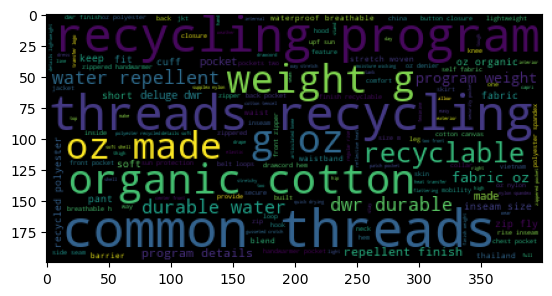

-----------
CLUSTER  0


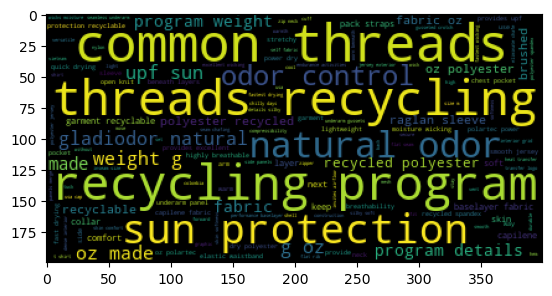

-----------
CLUSTER  4


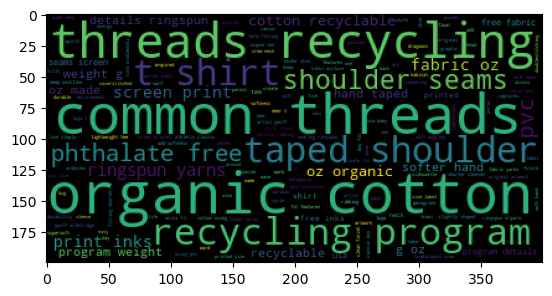

-----------


In [25]:
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:3] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## 3 Рекомендательная система <a class="anchor" id="chapter3"></a>

### 3.1. Рекомендации с TF-IDF векторизацией

In [31]:
recommend(cosine_similarities, item_id=56, num=5, threshold=0.5)

Товар найден :
Iceberg t-shirt - The effects of global warming run deep, depicted here on the Iceberg T-Shirt with artwork by wood block print artist Nick Wroblewski. Made from 100% ringspun organic cotton and printed with PVC- and phthalate-free inks, the shirt has taped shoulder seams for added comfort. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Ringspun yarns for a softer hand</li> <li>Taped shoulder seams</li> <li>Screen-print inks are PVC- and phthalate-free</li></ul><br><br><b>Fabric: </b>5.4-oz 100% organic cotton. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(199 g 6.9 oz)<br><br>Made in USA.
Топ 5 товаров, похожих на Iceberg t-shirt...
-------
Item # 490
Товар Flying fish 2 t-shirt (score:0.5649306947361032)
Item # 396
Товар Wind path t-shirt (score:0.5269111263888898)
Item # 115
Товар Rockpile t-shirt (score:0.5233727958983995)
Item # 123
Товар Squid t-shirt (score:0.5219809856766473)
Item # 97
Това

### 3.2. Рекомендации с word2vec векторизацией

In [32]:
recommend(cosine_similarities_w2v, item_id=56, num=5, threshold=0.999)

Товар найден :
Iceberg t-shirt - The effects of global warming run deep, depicted here on the Iceberg T-Shirt with artwork by wood block print artist Nick Wroblewski. Made from 100% ringspun organic cotton and printed with PVC- and phthalate-free inks, the shirt has taped shoulder seams for added comfort. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Ringspun yarns for a softer hand</li> <li>Taped shoulder seams</li> <li>Screen-print inks are PVC- and phthalate-free</li></ul><br><br><b>Fabric: </b>5.4-oz 100% organic cotton. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(199 g 6.9 oz)<br><br>Made in USA.
Топ 5 товаров, похожих на Iceberg t-shirt...
-------
Item # 115
Товар Rockpile t-shirt (score:0.9993350871087646)
Item # 101
Товар Planer t-shirt (score:0.9990870279784307)
Item # 447
Товар Cerro torre one t-shirt (score:0.9990729080071231)


### 3.3. Рекомендации с doc2vec векторизацией

In [33]:
recommend(cosine_similarities_d2v, item_id=56, num=5, threshold=0.83)

Товар найден :
Iceberg t-shirt - The effects of global warming run deep, depicted here on the Iceberg T-Shirt with artwork by wood block print artist Nick Wroblewski. Made from 100% ringspun organic cotton and printed with PVC- and phthalate-free inks, the shirt has taped shoulder seams for added comfort. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Ringspun yarns for a softer hand</li> <li>Taped shoulder seams</li> <li>Screen-print inks are PVC- and phthalate-free</li></ul><br><br><b>Fabric: </b>5.4-oz 100% organic cotton. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(199 g 6.9 oz)<br><br>Made in USA.
Топ 5 товаров, похожих на Iceberg t-shirt...
-------
Item # 236
Товар Wheat t-shirt (score:0.8607602)
Item # 288
Товар Owlin around t-shirt (score:0.84453607)
Item # 115
Товар Rockpile t-shirt (score:0.84356505)
Item # 168
Товар Bouquet t-shirt (score:0.84256035)
Item # 67
Товар La surfer maria t-shirt (score:0.8

### 3.4. Рекомендации с кластеризацией

In [34]:
claster_recommend(item_id=6)

Товар найден :
ascensionist jkt - our most technical soft shell for full-on mountain pursuits strikes the alpinist's balance between protection and minimalism. the dense  -way-stretch polyester double weave, with stitchless seams, has exceptional water- and wind-resistance, a rapid dry time and superb breathability. pared-down detailing provides everything you need and nothing more: a  -way-adjustable, helmet-compatible hood; a reverse-coil center-front zipper with a dwr  durable water repellent  finish; large external handwarmer pockets  with zipper garages  that are placed above the harness-line; an internal security pocket; articulated arms; self-fabic cuff tabs; a drawcord hem. recyclable through the common threads recycling program.   details:     dense stretchy polyester double-weave fabric is exceptionally water- and wind-resistant and is spandex-free for fast dry times; stitch-free, lap-glued seams speed dry time, improve water resistance and decrease bulk     helmet-compatible